In [1]:
from tensorflow.keras import datasets, layers, models

import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mlp
import time

In [2]:
def padImage(image, pixels=5):
    bottom = image[-pixels:]
    top = image[:pixels]

    img = np.insert(image, 0, bottom, 0)
    img = np.insert(img, len(img), top, 0)
    img = np.insert(img, [0], [0] * pixels, 1)
    img = np.insert(img, [-1], [0] * pixels, 1)
    return img

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = (train_images / 255.0).astype(np.float32), test_images.astype(np.float32) / 255.0
test = np.loadtxt('mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat')

In [4]:
### THE PAD HAS TO BE DONE IN THE
### POLAR SPACE

# 20 is the ceiling of (14 * sqrt(2))
X_train_polar = [cv.linearPolar(x, tuple(np.array(x.shape)/2), 20, cv.WARP_FILL_OUTLIERS) for x in train_images]
X_train_polar = [padImage(x, pixels=5) for x in X_train_polar]
X_train_polar = np.array(X_train_polar)[...,None]

X_test_polar = [cv.linearPolar(x, tuple(np.array(x.shape)/2), 20, cv.WARP_FILL_OUTLIERS) for x in test_images]
X_test_polar = [padImage(x, pixels=5) for x in X_test_polar]
X_test_polar = np.array(X_test_polar)[...,None]

# Rotate test set
X_test_r_polar = [tfa.image.rotate(x, np.random.uniform(-np.pi/2., np.pi/2.)).numpy() for x in test_images]
X_test_r_polar = [cv.linearPolar(x, tuple(np.array(x.shape)/2), 20, cv.WARP_FILL_OUTLIERS) for x in X_test_r_polar]
X_test_r_polar = [padImage(x, pixels=5) for x in X_test_r_polar]
X_test_r_polar = np.array(X_test_r_polar)[...,None]

In [56]:
# Logic so far:
# Trying Pool1D on the columns as polar is invariant horizontally, but varies on the y-axis wrt. rotations
inputs = tf.keras.Input(shape=(38, 38, 1))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True)(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True)(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
#x = layers.GlobalMaxPool2D()(x) 

### First approach - using: tf.math.reduce_max() => Flatten
# global max pool on the col - axis = 1 (from interpretation below)
x = tf.math.reduce_max(x, axis=1, keepdims=True)
x = layers.Flatten()(x)

### Second approach - using: Transpose => GlobalMaxPooling1D => Flatten
#x = tf.transpose(x, (2, 1, 0, 3)) # change to: c,r,batch_s,filters
#x = layers.GlobalMaxPool1D()(x)  # Gives error here
#x = layers.Flatten()(x)

x = layers.Dense(64, activation='linear')(x)
x = layers.Activation('relu')(x)

x = layers.Dense(10, activation='softmax')(x)

model_x = models.Model(inputs=inputs, outputs=x)

In [57]:
model_x.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 38, 38, 1)]       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 36, 36, 32)        320       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
layer_normalization_30 (Laye (None, 18, 18, 32)        64        
_________________________________________________________________
dropout_30 (Dropout)         (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 8, 64)          0  

In [58]:
name = 'col_pool'
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
checkpoint = tf.keras.callbacks.ModelCheckpoint(name + '.h5', verbose=1, save_best_only=True, monitor='val_loss', mode='min')
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.000, patience=5, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)


model_x.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_x.fit(X_train_polar, train_labels, batch_size=128, epochs=10, 
          validation_data=(X_test_r_polar, test_labels),
          callbacks=[reduce_lr, checkpoint, es])

Epoch 1/10
469/469 [==============================] - 51s 108ms/step - loss: 1.0910 - accuracy: 0.6378 - val_loss: 0.5712 - val_accuracy: 0.8365

Epoch 00001: val_loss improved from inf to 0.57116, saving model to col_pool.h5
Epoch 2/10
469/469 [==============================] - 50s 107ms/step - loss: 0.1815 - accuracy: 0.9443 - val_loss: 0.7110 - val_accuracy: 0.8011

Epoch 00002: val_loss did not improve from 0.57116
Epoch 3/10
469/469 [==============================] - 49s 104ms/step - loss: 0.1307 - accuracy: 0.9598 - val_loss: 0.5233 - val_accuracy: 0.8439

Epoch 00003: val_loss improved from 0.57116 to 0.52332, saving model to col_pool.h5
Epoch 4/10
469/469 [==============================] - 47s 101ms/step - loss: 0.1147 - accuracy: 0.9645 - val_loss: 0.5915 - val_accuracy: 0.8287

Epoch 00004: val_loss did not improve from 0.52332
Epoch 5/10
469/469 [==============================] - 47s 101ms/step - loss: 0.0994 - accuracy: 0.9695 - val_loss: 0.6212 - val_accuracy: 0.8298

Epoc

## Illustration that the first k, will be the column interpretation

In [54]:
a = tf.constant([[1,2,3], [1,2,3], [1,2,3]])
a, tf.reduce_max(a, axis=0)

(<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
 array([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>)

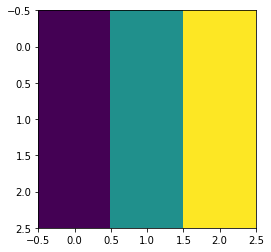

In [53]:
plt.imshow(a)